<a href="https://colab.research.google.com/github/RANJEET16520/Humour-Detection/blob/master/xlnet_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
 
import psutil
import humanize
import os
import GPUtil as GPU
 
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=0d7ba69142069993b7cda5a8da99dc4faf8f293264ef1ac84e1e1fe7594b2615
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  |     Proc size: 159.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [ ]:
!pip install transformers
!pip install pytorch_transformers

     |████████████████████████████████| 778kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 20.1MB/s 
     |████████████████████████████████| 890kB 35.6MB/s 
     |████████████████████████████████| 3.0MB 42.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3cb912351f93f702900ee1043131700acfbd960829ee451d88ea5a3856b977f6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 6.5MB/s 


In [ ]:
import os
import math
import glob
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from pytorch_transformers import AdamW, WarmupLinearSchedule
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))
print("Current Device is {}".format('GPU' if torch.cuda.current_device()==0 else 'CPU'))
torch.cuda.set_device(0)

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB
Current Device is GPU


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
cd drive/My Drive/Colab Notebooks/apex

/content/drive/.shortcut-targets-by-id/1_A25iC8PhwLE9n1Xyst3s1mB57L9kbs3/apex


In [ ]:
! python setup.py install --cuda_ext --cpp_ext



torch.__version__  = 1.5.1+cu101


setup.py:51: UserWarning: Option --pyprof not specified. Not installing PyProf dependencies!
  warnings.warn("Option --pyprof not specified. Not installing PyProf dependencies!")

Compiling cuda extensions with
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
from /usr/local/cuda/bin

running install
running bdist_egg
running egg_info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
/usr/local/lib/python3.6/dist-packages/torch/utils/cpp_extension.py:305: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/b

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Data/New_200K_Jokes/train.csv')
train.shape

(160000, 2)

In [ ]:
dev = pd.read_csv('/content/drive/My Drive/Data/New_200K_Jokes/dev.csv')
dev.shape

(40000, 2)

In [ ]:
train.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [ ]:
train['number_of_words'] = train.text.apply(lambda x: len(x.split()))

In [ ]:
train.dtypes

text               object
humor                bool
number_of_words     int64
dtype: object

In [ ]:
dev.head()

,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True
3,"What's 6 inches long hard, bent, and in my pan...",True
4,Black teen's response to violence in his commu...,False


In [ ]:
dev['number_of_words'] = dev.text.apply(lambda x: len(x.split()))

In [ ]:
dev.dtypes

text               object
humor                bool
number_of_words     int64
dtype: object

In [ ]:
def Visual(df):
    max_len = max(df.number_of_words)
    print('Length of Data = {}'.format(len(df)))
    print('No. of item with output 0 are = {}'.format(len(df[df['humor']==True])))
    print('No. of item with output 1 are = {}'.format(len(df[df['humor']==False]))) 
    print('Maximum length of a text in all texts = {}'.format(max_len)) 

In [ ]:
Visual(train)

Length of Data = 160000
No. of item with output 0 are = 79918
No. of item with output 1 are = 80082
Maximum length of a text in all texts = 18


In [ ]:
Visual(dev)

Length of Data = 40000
No. of item with output 0 are = 20082
No. of item with output 1 are = 19918
Maximum length of a text in all texts = 18


In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

INFO:filelock:Lock 140559625834000 acquired on /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpuclze1rq


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model in cache at /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8
INFO:filelock:Lock 140559625834000 released on /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8.lock
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model from cache at /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc

In [ ]:
train_text_list = train["text"].values

In [ ]:
dev_text_list = dev["text"].values

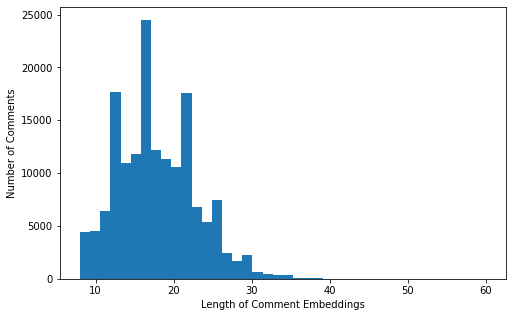

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

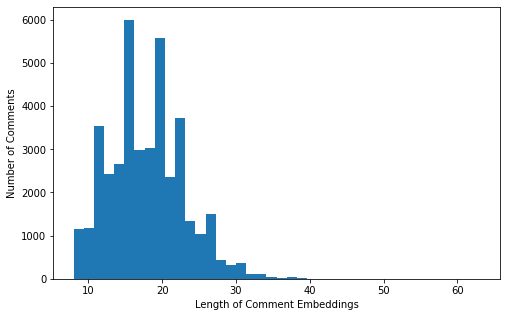

In [ ]:
plot_sentence_embeddings_length(dev_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    input_ids = np.array(input_ids)
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    attention_masks = np.array(attention_masks)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50)
print(train_input_ids.shape)
train_input_ids

(160000, 50)


array([[   17,  2595,    93, ...,     0,     0,     0],
       [ 1628,    60,    17, ...,     0,     0,     0],
       [  113,   112,    44, ...,     0,     0,     0],
       ...,
       [  108,   886,   855, ...,     0,     0,     0],
       [   17,   150,    26, ...,     0,     0,     0],
       [ 2302, 10738,    61, ...,     0,     0,     0]])

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
train_attention_masks.shape

(160000, 50)

In [ ]:
# create input id tokens
dev_input_ids = tokenize_inputs(dev_text_list, tokenizer, num_embeddings=50)
print(dev_input_ids.shape)
dev_input_ids

(40000, 50)


array([[  113,   713,    20, ...,     0,     0,     0],
       [ 1633,    90,   104, ...,     0,     0,     0],
       [12879,    27,   426, ...,     0,     0,     0],
       ...,
       [  160,   142,  8959, ...,     0,     0,     0],
       [   17,    98,   369, ...,     0,     0,     0],
       [   48,    17,  1121, ...,     0,     0,     0]])

In [ ]:
# create attention masks
dev_attention_masks = create_attn_masks(dev_input_ids)
dev_attention_masks.shape

(40000, 50)

In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks.tolist()
train.head()

,text,humor,number_of_words,features,masks
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,10,"[17, 2595, 93, 2340, 254, 1414, 78, 15765, 234...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Watch: darvish gave hitter whiplash with slow ...,False,8,"[1628, 60, 17, 5072, 25489, 675, 17, 11753, 14...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,What do you call a turtle without its shell? d...,True,10,"[113, 112, 44, 547, 24, 15700, 286, 81, 6197, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,5 reasons the 2016 election feels so personal,False,8,"[306, 2113, 18, 2884, 821, 4760, 102, 739, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"Pasco police shot mexican migrant from behind,...",False,10,"[943, 19301, 365, 938, 110, 6269, 2392, 21726,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
# add input ids and attention masks to the dataframe
dev["features"] = dev_input_ids.tolist()
dev["masks"] = dev_attention_masks.tolist()
dev.head()

,text,humor,number_of_words,features,masks
0,What kind of cat should you take into the des...,True,16,"[113, 713, 20, 4777, 170, 44, 182, 91, 18, 567...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Remember when people used to have to be in sha...,True,14,"[1633, 90, 104, 179, 22, 47, 22, 39, 25, 2787,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,Pizza is always good. - everyone we'll see abo...,True,13,"[12879, 27, 426, 195, 9, 17, 13, 1251, 80, 26,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"What's 6 inches long hard, bent, and in my pan...",True,13,"[113, 26, 23, 284, 3763, 206, 500, 19, 9015, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,Black teen's response to violence in his commu...,False,11,"[710, 8017, 26, 23, 1196, 22, 1350, 25, 45, 53...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
    def __init__(self, num_labels=1):
        super(XLNetForMultiLabelSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.classifier = torch.nn.Linear(768, num_labels)

        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # last hidden layer
        last_hidden_state = self.xlnet(input_ids=input_ids,\
                                    attention_mask=attention_mask,\
                                    token_type_ids=token_type_ids)
        # pool the outputs into a mean vector
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        logits = self.classifier(mean_last_hidden_state)
            
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits

    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
    
    def unfreeze_xlnet_decoder(self):
        """
        Unfreeze XLNet weight parameters. They will be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = True

    def pool_hidden_state(self, last_hidden_state):
        """
        Pool the output vectors into a single mean vector 
        """
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state

model = XLNetForMultiLabelSequenceClassification(num_labels=1)
# model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')
model.cuda()

INFO:filelock:Lock 140556899865152 acquired on /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp8vaumgx9


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json in cache at /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
INFO:filelock:Lock 140556899865152 released on /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e4

INFO:filelock:Lock 140556900196816 acquired on /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/xlnet-base-cased-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp248g7tkp


INFO:transformers.file_utils:storing https://cdn.huggingface.co/xlnet-base-cased-pytorch_model.bin in cache at /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac
INFO:filelock:Lock 140556900196816 released on /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/xlnet-base-cased-pytorch_model.bin from cache at /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac


INFO:transformers.modeling_utils:All model checkpoint weights were used when initializing XLNetModel.

INFO:transformers.modeling_utils:All the weights of XLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use XLNetModel for predictions without further training.


XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), ep

In [ ]:
def trainnig(device, model, num_epochs, optimizer, scheduler, train_dataloader, valid_dataloader, model_save_path, start_epoch=0, lowest_eval_loss=None, train_loss_set=[], valid_loss_set = []):
    """
    Train the model and save the model with the lowest validation loss
    """
    logger.info("***** Running training *****")
    logger.info("  Total train batch size = %d", len(train_dataloader))
    logger.info("  Total validation batch size  = %d", len(valid_dataloader))
    logger.info("  Num Epochs = %d", num_epochs)
    
    if True:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    model = torch.nn.DataParallel(model)
   
    model.to(device)
 
    # trange is a tqdm wrapper around the normal python range
    for i in trange(num_epochs, desc="Epoch"):
        # if continue training from saved model
        actual_epoch = start_epoch + i + 1
        print("\n\n\n***** Epoch No.: {} *****\n".format(actual_epoch))
        # Training
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()
 
        # Tracking variables
        tr_loss = 0
        num_train_samples = 0
 
        # Train the data for one epoch
        batch_no = 0
        for step, batch in enumerate(train_dataloader):
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            batch_no += 1
            
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # Clear out the gradients (by default they accumulate)
            optimizer.zero_grad()
            # Forward pass
            loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            # store train loss
            tr_loss += loss.item()
            num_train_samples += b_labels.size(0)
            # Backward pass
            loss.backward()
            # Update parameters and take a step using the computed gradient
            optimizer.step()
            scheduler.step()
 
        # Update tracking variables
        epoch_train_loss = tr_loss/num_train_samples
        train_loss_set.append(epoch_train_loss)
 
        print("\nTrain loss: {}".format(epoch_train_loss))
 
        # Validation
 
        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()
 
        # Tracking variables 
        eval_loss = 0
        num_eval_samples = 0
 
        # Evaluate data for one epoch
        for batch in valid_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
            # Forward pass, calculate validation loss
                loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                # store valid loss
                eval_loss += loss.item()
                num_eval_samples += b_labels.size(0)
 
        epoch_eval_loss = eval_loss/num_eval_samples
        valid_loss_set.append(epoch_eval_loss)
 
        print("\nValid loss: {}".format(epoch_eval_loss))
 
        if lowest_eval_loss == None:
            lowest_eval_loss = epoch_eval_loss
            # save model
            save_model(model, model_save_path, actual_epoch, lowest_eval_loss, train_loss_set, valid_loss_set)
        else:
            if epoch_eval_loss < lowest_eval_loss:
                lowest_eval_loss = epoch_eval_loss
                # save model
                save_model(model, model_save_path, actual_epoch, lowest_eval_loss, train_loss_set, valid_loss_set)
        print("\n")
 
    return model, train_loss_set, valid_loss_set
 
 
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
    """
    Save the model to the path directory provided
    """
    model_to_save = model.module if hasattr(model, 'module') else model
    checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
                }
    torch.save(checkpoint, save_path)
    print("\nSaving model at epoch {} with validation loss of {}".format(epochs,lowest_eval_loss))
    return
  
def load_model(save_path):
    """
    Load the model from the path directory provided
    """
    checkpoint = torch.load(save_path)
    model_state_dict = checkpoint['state_dict']
#     model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
    model.load_state_dict(model_state_dict)
 
    epochs = checkpoint["epochs"]
    lowest_eval_loss = checkpoint["lowest_eval_loss"]
    train_loss_hist = checkpoint["train_loss_hist"]
    valid_loss_hist = checkpoint["valid_loss_hist"]
 
    return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
X_train = train["features"].values.tolist()
X_valid = dev["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = dev["masks"].values.tolist()

label_cols = ["humor"]
Y_train = train[label_cols].values.tolist()
Y_valid = dev[label_cols].values.tolist()

In [ ]:
print('One Example of X_train:\n{}\n'.format(X_train[0]))
print('One Example of X_valid:\n{}\n'.format(X_valid[0]))

print('One Example of train_masks:\n{}\n'.format(train_masks[0]))
print('One Example of valid_masks:\n{}\n'.format(valid_masks[0]))

print('One Example of Y_train:\n{}\n'.format(Y_train[0]))
print('One Example of Y_valid:\n{}\n'.format(Y_valid[0]))

One Example of X_train:
[17, 2595, 93, 2340, 254, 1414, 78, 15765, 2340, 60, 17, 26, 3017, 117, 23, 19, 17, 150, 26, 98, 50, 926, 26, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

One Example of X_valid:
[113, 713, 20, 4777, 170, 44, 182, 91, 18, 5675, 17, 82, 24, 89, 1443, 8538, 982, 17, 136, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

One Example of train_masks:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

One Example of valid_masks:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

One Example of 

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
num_epochs = 3
num_total_steps = len(train_dataloader)*num_epochs
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/My Drive/Data/New_200K_Jokes/xlnet_toxic.bin")
if os.path.exists(model_save_path):
    print('Yes file Exists!')
    os.remove(model_save_path)
    print('Now, xlnet_toxic.bin File is removed!!')

Yes file Exists!
Now, xlnet_toxic.bin File is removed!!


In [ ]:
printm()

Gen RAM Free: 10.1 GB  |     Proc size: 4.9 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [ ]:
torch.cuda.empty_cache()
model, train_loss_set, valid_loss_set = trainnig(device = device, model=model, num_epochs=num_epochs, optimizer=optimizer,scheduler=scheduler, train_dataloader=train_dataloader, valid_dataloader=validation_dataloader, model_save_path=model_save_path)

INFO:__main__:***** Running training *****
INFO:__main__:  Total train batch size = 5000
INFO:__main__:  Total validation batch size  = 1250
INFO:__main__:  Num Epochs = 3
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



***** Epoch No.: 1 *****



/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Train loss: 0.0021679473160605995

Valid loss: 0.0016755193166576646


Epoch:  33%|███▎      | 1/3 [19:36<39:12, 1176.30s/it]


Saving model at epoch 1 with validation loss of 0.0016755193166576646





***** Epoch No.: 2 *****


Train loss: 0.0012292418639344759

Valid loss: 0.0013109843694721348


Epoch:  67%|██████▋   | 2/3 [39:10<19:35, 1175.75s/it]


Saving model at epoch 2 with validation loss of 0.0013109843694721348





***** Epoch No.: 3 *****


Train loss: 0.0008756775609565921


Epoch: 100%|██████████| 3/3 [58:42<00:00, 1174.01s/it]


Valid loss: 0.001590783386432031




In [ ]:
printm()

Gen RAM Free: 10.0 GB  |     Proc size: 4.9 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


Text(0.5, 1.0, 'Loss vs Number of Epochs')

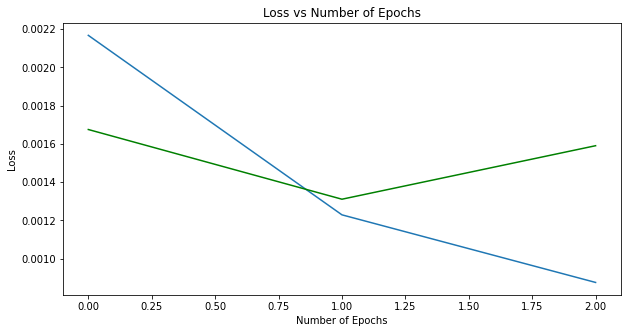

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))
 
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")